# Let's Get Linear: Spectral Clustering

Clustering is a natural form of data analysis; finding groups of similar data points could tell you a bunch about the data set. For example, it can be used to detect spam by clustering emails into spam and non-spam, and and find patterns in images by finding blobs of similar colors. It's a form of unsupervised machine learning which means it doesn't depend on pre-labelled data --- we don't know at the start whether a data point is in cluster one or two, for example. 

Using spectral clustering instead of a plain old k-means clustering algorithm can bring about some interesting patterns in data. Spectral clustering a form of dimension reduction with a bunch of linear algebra concepts behind it, so let's explore it! 

Let's first get our imports in.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import linalg as LA

from sklearn.cluster import KMeans
from scipy.spatial import distance 

import spec_clust as sc

And import our toy example for this notebook.

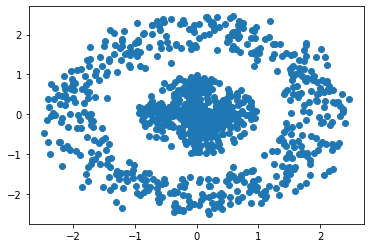

In [17]:
my_data = np.loadtxt("spec_clust_data.csv", delimiter = ",")
plt.scatter(my_data[:,0], my_data[:,1])

In this data, we can see that there's probably around two clusters here: the middle circle and the outside ring. 

Let's see how kmeans performs on this data.

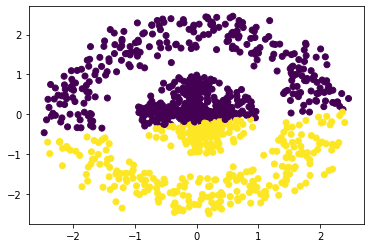

In [19]:
labels, centers = sc.full_kmeans(my_data, 2)
plt.scatter(my_data[:,0], my_data[:,1], c = labels)

This clustering is not so great. The k-means ignores the idea of a middle circle and outside ring, and instead seems to just slice our data in half. This provides a motivation for a more nuanced clustering algorithm: spectral clustering!

Let's run this code block to see how spectral clustering would work on this data.

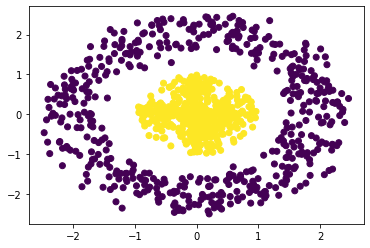

In [36]:
A = sc.make_adj(my_data)
L = sc.my_laplacian(A)
sc_labels, sc_centers = sc.spect_clustering(L, 2)
plt.scatter(my_data[:,0], my_data[:,1], c = sc_labels)

We can see that spectral clustering does a much better job than k-means at clustering our data. 

One advantage of spectral clustering over k-means is that the clusters can be any shape. In k-means, the clusters form around the center of the cluster in sort of a ball shape, because it's primary way of telling whether a point is in a cluster is by how close the point is to the center. That's why, in k-means, the idea of a cluster being within the cluster doesn't make sense. 

But in spectral clustering, we aren't mapping our clusters using the cartesian graph itself, but instead within a "similarity" space. More specifically, we are redefining a point being part of a cluster as a point being "similar" to other points inside of it. More on this in a second.


## The nitty-gritty

Let's go through a spectral clustering implementation to learn more about it, as well as the linear algebra behind it. 

### Making the Laplacian matrix

The Laplacian matrix is really cool way to visualize a graph mades of nodes and edges. Let's consider a node to be a data point, and an edge to exist between two nodes if they are "close enough," which in this implementation means their internode distance is less than .5.

The Laplacian matrix, which I'll be calling L from now on is defined as $L = D - A$, where D represents the degree of each point on a diagonal(degree means how many nodes it shares an edge with), and A represents the edges of matrix, as the i,jth spot on the matrix will be 1 if there's an edge between node i and node j.

Just to keep the matrices straight, let's remember that the ith row and ith column refer to the ith point. It's cool to see that the matrices are symmetric!

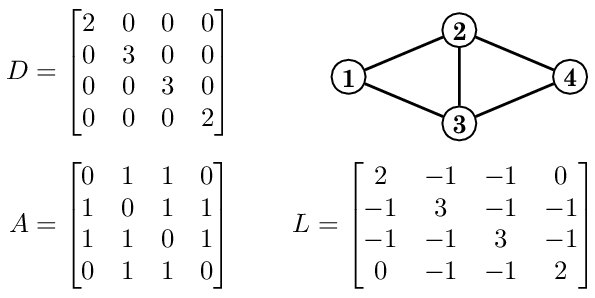

Visualizing our data as a graph like this helps us give our concept of a cluster a little bit more depth. Spectral clustering would say that, even if a node i doesn't share an edge with node j, they are probably in the same cluster if they are connected to other nodes in a similar way. 

Now let's check out the implementation contained in the document `spec_clust.py`

In [22]:
'''
mak_adj takes in a numpy array array_np
then creates an adjacency matrix between the points of array_np
'''
def make_adj(array_np):
    #calculate the distance between all points
    adj_mat = distance.cdist(array_np, array_np, 'euclidean') 

    for i in range(len(adj_mat)):
        for j in range(len(adj_mat[0,:])):
            #if i and j are the same point...
            if i == j: 
                adj_mat[i,j] = 0
            #if they are too far apart...
            elif adj_mat[i,j] >= .5: # edge exists if the internode distance is less than .5
                adj_mat[i,j] = 0
            #if they are close enough...
            else:
                adj_mat[i,j] = 1

    return adj_mat

'''
my_laplacian takes in adjacency matrix A
then creates a Laplacian matrix from A
'''
def my_laplacian(adj_mat): 
    #D counts up the degree of each point by summing up 
    #the number of points that a point is next to
    D = np.diag(np.sum(adj_mat, axis = 1))
    
    #subtract the adjacency matrix from degrees matrix
    return np.subtract(D, adj_mat)

And let's take a look into these matrices.

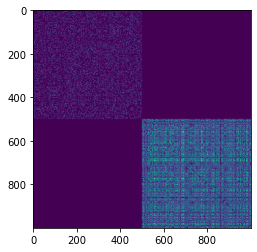

In [38]:
plt.imshow(A) # A is the edge/adjacency matrix

In this matrix, we can see where the adjacencies are happening; the adjacencies light up here as blue. The first quadrant, which represents the top 50% of the data, has a few adjacencies here and there within themselves. The fourth quadrant, which represents the second half of the data, has many edges within themselves.

Well, it seems like this adjacency matrix provides some cool information about how the datapoints group up. What happens if we run k-means on it?

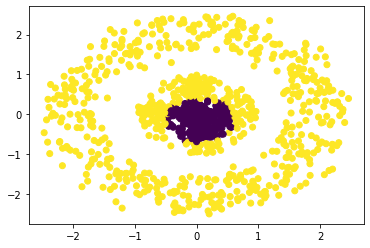

In [40]:
a_labels, a_centers = sc.full_kmeans(A, 2)
plt.scatter(my_data[:,0], my_data[:,1], c = a_labels)

Using A is an improvement from plain k-means, but we know we can do better than this. Let's dig into L next. 

### Laplacian Eigenvectors

Now let's think about what information we can extract from L, namely, the eigenvectors! Let's keep in mind that since L is a square matrix, L's eigenvectors form an orthonormal basis for L. So there are the same number of L's eigenvectors as there are datapoints, and each eigenvector's length is the same as the number of datapoints.

Laplacian eigenvectors are known to show lots about the locality of the data, meaning that they show us information about the individual nodes rather than the graph as a whole. 

Hata and Nakoa (2017) explain the use of L's eigenvectors: "A remarkable property of the Laplacian eigenvectors on random networks is their localization with respect to the node degrees. Namely, the components of each eigenvector take relatively large values on a particular subset of nodes, while taking small values otherwise. Moreover, the localized nodes have similar degrees, i.e., numbers of edges, and this characteristic degree corresponds closely with the Laplacian eigenvalue (We say that a pair of nodes have “similar degrees” when the difference in their degrees is sufficiently smaller than the range of the entire degree distribution)"

Since we know that each component in the eigenvector corresponds to a node, what this is telling is that, in a given eigenvector, a sort of clustering is already going on, where similar nodes are given a similar value in the eigenvector. This is what is meant by "similarity" space --- we're creating a matrix of eigenvectors that describe the similarity between data points. 

To give a sneak peek, let's take a look at one of the eigenvectors for the data, as numbers and graphed on a spectrum.

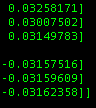

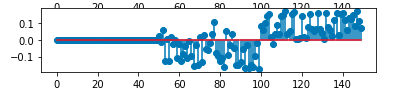

The six values are from one eigenvectors for the data, but don't comprise the entirety of it of course. The top three values in the first image correspond to points in one cluster, while the second three correspond to points in another cluster. The graph shows these values on the spectrum on the y axis, for each point on the x axis. In this eigenvector, we have a spectrum of values that correspond to each datapoint's similarity, and we can see how they separate out through this spectrum image. 

From here, we can sense that with a few good eigenvectors, performing k-means on the eigenvectors to cluster our original data would cluster on this idea of similarity. And that's exactly what spectral clustering does!

Let's look into the spectral clustering implementation contained in `spec_clust.py`

In [ ]:
'''
spect_clustering takes in a Laplacian L and a number of eigenvectors k
then computes k-means on the eigenenvectors
'''
def spect_clustering(L, k):
    #compute eigen vectors
    w, v = LA.eig(L)

    #sort eigenvectors by their corresponding eigenvalues
    idx = np.argsort(w)
    sorted_vex = v[:, idx]

    #select first k eigenvectors
    #kmeans on eigenvectors
    return full_kmeans(sorted_vex[:, 0:k], k)

Interestingly, we are sorting the eigenvectors based on the eigenvalues. This is because the eigen values relate to the importance of each eigenvector; they can be used as scalars to create a linear equation for a matrix. We also know that L is always positive semi-definite, which means that all of it's eigenvalues are positive, because it's a symmetric matrix. With this knowledge, it's easy to `argsort` the eigenvalue list to find which eigenvectors would be the best to perform the k-means on. 

This is what the k-means on the 2 eigenvectors looks like, by the way:

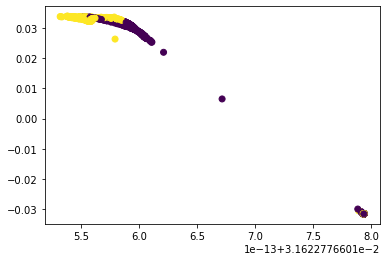

In [41]:
#eigenvalues and eigenvectors for L
w, v = LA.eig(L)

#sort eigenvectors by their corresponding eigenvalues
idx = np.argsort(w)
sorted_vex = v[:, idx]

#select first k eigenvectors
#kmeans on eigenvectors
v_labels, v_centers = sc.full_kmeans(sorted_vex[:, 0:2], 2)

plt.scatter(sorted_vex[:,0], sorted_vex[:,1], c = labels)

## Conclusion 

Spectral clustering capitalizes on the localization that the laplacian eigenvectors tell us about. This method makes spectral clustering a more nuanced algorithm than k-means, as it changes the possible shapes of clusters. Yet, it is a bit more computationally expensive than k-means, because it requires the extra matrix manipulation and eigenvector calculations. 

## Sources
- https://www.researchgate.net/figure/An-example-of-the-Laplacian-matrix-of-a-simple-network-n-4_fig1_305653264
- https://www.nature.com/articles/s41598-017-01010-0
